In [24]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler,LabelEncoder

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input,Concatenate
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import TimeDistributed, RepeatVector
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

import matplotlib.pyplot as plt
import os

In [25]:

def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []  # 用于存储输入序列和对应目标值
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])  # 从 X 中截取 seq_length 个连续时间步的数据
        y_seq.append(y[i+seq_length])    # 目标值是第 seq_length + 1 个时间步的值
    return np.array(X_seq), np.array(y_seq)  # 转换为 NumPy 数组，便于模型输入

def pre_processing(seq_length, epoch_size):
    # 1. 数据加载与预处理
    # 假设 data.csv 包含多个特征和时间步的房价数据
    price_data = pd.read_excel('file/medianAskingRent.xlsx')  

    inventory_data = pd.read_excel('file/rentalInventory.xlsx') 

    # 2. 清理房源数量数据
    inventory_long = pd.melt(inventory_data, id_vars=['areaName', 'Borough'], var_name='YearMonth', value_name='InventoryCount') #将数据转换为长格式
    price_long=pd.melt(price_data, id_vars=['areaName', 'Borough'], var_name='YearMonth', value_name='Price') #将数据转换为长格式
    #print(inventory_long)
    #print(price_long)

    # 3. 合并房源数量和房价数据
    merged_data = pd.merge(inventory_long, price_long, on=['areaName', 'Borough', 'YearMonth'], how='inner')
    #print(merged_data)

    # 4. 保存结果到 CSV
    output_file = 'file/final_data.xlsx'
    merged_data.to_excel(output_file, index=False)

    # 5. 查看最终输出
    #print("数据已保存至:", output_file)
    #print(merged_data.head())

    # 6. 时间特征提取
    merged_data['YearMonth'] = pd.to_datetime(merged_data['YearMonth'])
    merged_data['Year'] = merged_data['YearMonth'].dt.year
    merged_data['Month'] = merged_data['YearMonth'].dt.month

    # 社区编码
    le = LabelEncoder()
    merged_data['areaName'] = le.fit_transform(merged_data['areaName'])

    #去除空值
    merged_data = merged_data.dropna(subset=['areaName', 'InventoryCount', 'YearMonth', 'Price'])

    # 月份编码
    merged_data['month_sin'] = np.sin(2 * np.pi * merged_data['Month'] / 12)
    merged_data['month_cos'] = np.cos(2 * np.pi * merged_data['Month'] / 12)


    seq_features = ['month_sin', 'month_cos','Year']
    static_features = ['areaName','InventoryCount','Price']
    target = 'Price'

    # 数据标准化
    scaler_static= MinMaxScaler()
    scaled_static = scaler_static.fit_transform(merged_data[static_features])
    #print(scaled_static)

    scaler_seq = MinMaxScaler()
    scaled_seq = scaler_seq.fit_transform(merged_data[seq_features])
    #print(scaled_seq)

    # 数据标准化
    scaler_target = MinMaxScaler()
    scaled_target = scaler_target.fit_transform(merged_data[[target]])
    #print(scaled_target)

    scaled_seq_feature = merged_data[seq_features].values  # 提取时间序列特征 (Month)


    # 生成时间序列数据和目标值

    X_seq, y_seq = create_sequences(scaled_seq_feature, scaled_target, seq_length)

    X_static = scaled_static[seq_length:]  # 静态特征去掉前 seq_length 行
    #print(X_seq.shape, X_static.shape, y_seq.shape)

    # 划分训练集和测试集
    train_size = int(0.5 * len(X_seq))
    X_seq_train, X_seq_test = X_seq[:train_size], X_seq[train_size:]
    X_static_train, X_static_test = X_static[:train_size], X_static[train_size:]
    y_train, y_test = y_seq[:train_size], y_seq[train_size:]

    # 构建混合模型

    seq_input = Input(shape=(seq_length,len(seq_features)), name='seq_input')  # 时间序列输入层
    lstm_out = LSTM(50, activation='relu')(seq_input)  # LSTM 层，输出 50 维的特征


    # 静态特征输入（areaName、InventoryCount）
    static_input = Input(shape=(len(static_features),), name='static_input')  # 静态特征输入层
    static_out = Dense(32, activation='relu')(static_input)  # 全连接层，输出 32 维特征

    # 融合两部分
    combined = Concatenate()([lstm_out, static_out])  # 融合两部分特征

    # 输出层
    output = Dense(1, activation='linear')(combined)  # 输出层，预测目标值

    # 构建模型
    model = Model(inputs=[seq_input, static_input], outputs=output)  # 构建模型
    model.compile(optimizer='adam', loss='mse')  # 编译模型，使用 MSE 损失函数

    #model.summary()  # 输出模型结构

    # 训练模型
    model.fit(
        [X_seq_train, X_static_train],  # 第一个输入传递给 seq_input，第二个传递给 static_input
        y_train,
        epochs=epoch_size,
        batch_size=50,
        validation_data=([X_seq_test, X_static_test], y_test)
    )
    # 预测
    y_pred = model.predict([X_seq_test, X_static_test])
    #print("y_pred:\n")
    #print(y_pred)

    # 反归一化
    y_pred_original = scaler_target.inverse_transform(y_pred)
    y_test_original = scaler_target.inverse_transform(y_test)
    #print(y_pred_original)
    #print(y_test_original)

    # 绘制散点图：实际值 vs 预测值
    plt.figure(figsize=(12, 6))

    #print(merged_data['YearMonth'])
    # 实际值与预测值的散点图
    plt.scatter(merged_data['YearMonth'].iloc[-len(y_test_original):], y_test_original, label='Actual Price', color='blue', alpha=0.6)
    plt.scatter(merged_data['YearMonth'].iloc[-len(y_pred_original):], y_pred_original, label='Predicted Price', color='red', alpha=0.6)

    # 图表设置
    plt.title(f'Actual vs Predicted Housing Prices (epoch={epoch_size},seq={seq_length})')
    plt.xlabel('YearMonth')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)

    # 显示图表
    #plt.show()

    output_file = os.path.join("file", f'seq_{seq_length}_epoch_{epoch_size}.png')
    plt.savefig(output_file, dpi=300, bbox_inches='tight')  # 保存高分辨率图表
    #print(f"图表已保存至: {output_file}")

    # 计算评估指标
    mse = mean_squared_error(y_test_original, y_pred_original)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_original, y_pred_original)
    r2 = r2_score(y_test_original, y_pred_original)

    # 输出评估指标/
    #print(f"Ratings：")
    #print(f"MSE: {mse:.4f}")
    #print(f"RMSE: {rmse:.4f}") 
    #print(f"MAE: {mae:.4f}") # 绝对值差多少
    #print(f"R²: {r2:.4f}") # 1 表示完美预测, 表示模型解释了百分之多少的房价波动
    
    return mse,rmse,mae,r2


In [20]:
pre_processing(seq_length=5,epoch_size=100)

Epoch 1/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 93.6763 - val_loss: 0.0435
Epoch 2/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0266 - val_loss: 0.0199
Epoch 3/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0128 - val_loss: 0.0152
Epoch 4/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0099 - val_loss: 0.0091
Epoch 5/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054 - val_loss: 0.0055
Epoch 6/100
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 7/100
 90/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022

KeyboardInterrupt: 

Epoch 1/2
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 623.4861 - val_loss: 0.0402
Epoch 2/2
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0136 - val_loss: 0.0108
159/159 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 127.0452 - val_loss: 0.0274
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0204 - val_loss: 0.0295
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0179 - val_loss: 0.0285
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0172 - val_loss: 0.0237
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0164 - val_loss: 0.0222
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0155 - val_loss: 0.0211
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0145 - val_loss: 0.0218
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0133 - val_loss: 0.0204
Epoch 9/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0124 - val_loss: 0.0176
Epoch 10/

/var/folders/zn/q0n6kv411hj2dz8ryph2m0jh0000gn/T/ipykernel_87323/1258732786.py:126: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 6))


Epoch 1/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1561196.8750 - val_loss: 5.9666
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.0865 - val_loss: 0.0720
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0538 - val_loss: 0.0669
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0506 - val_loss: 0.0657
Epoch 5/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0483 - val_loss: 0.0613
Epoch 6/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0443 - val_loss: 0.0562
Epoch 7/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0425 - val_loss: 0.0569
Epoch 8/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0395 - val_loss: 0.0544
Epoch 9/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0372 - val_loss: 0.0536
Epoch 10/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0350 - val_loss: 0.0485
Epoch 11/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0338 - val_loss: 0.0450
Epoch 12/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6m

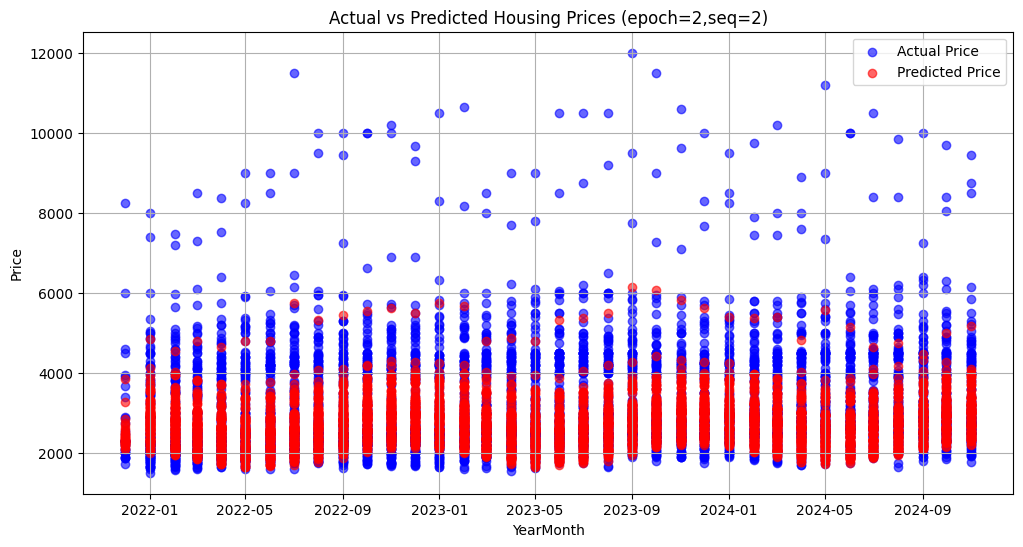

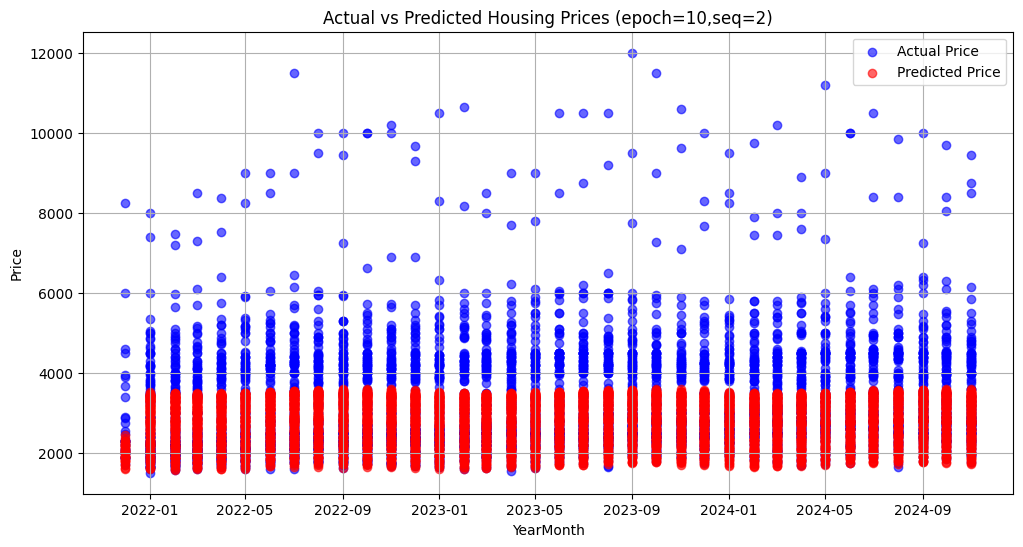

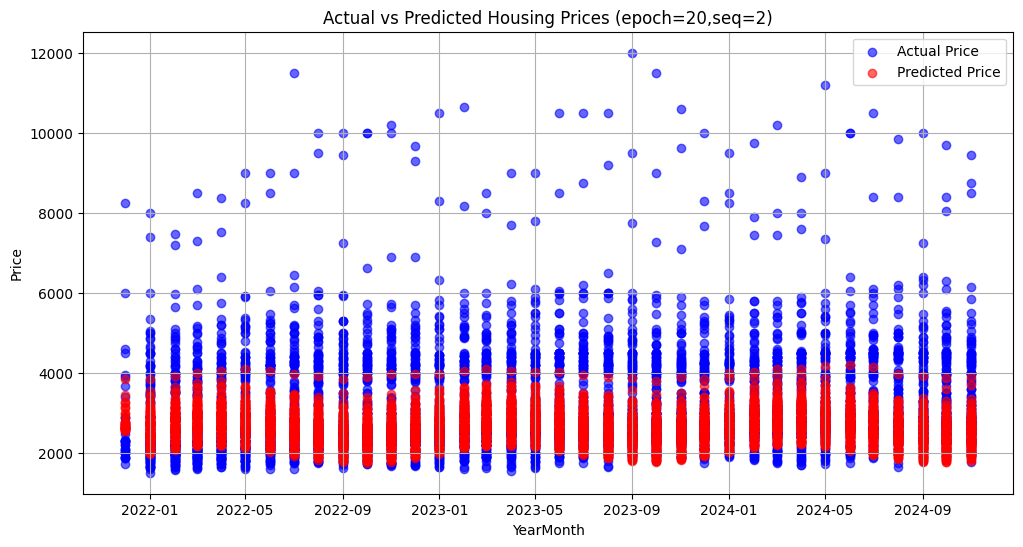

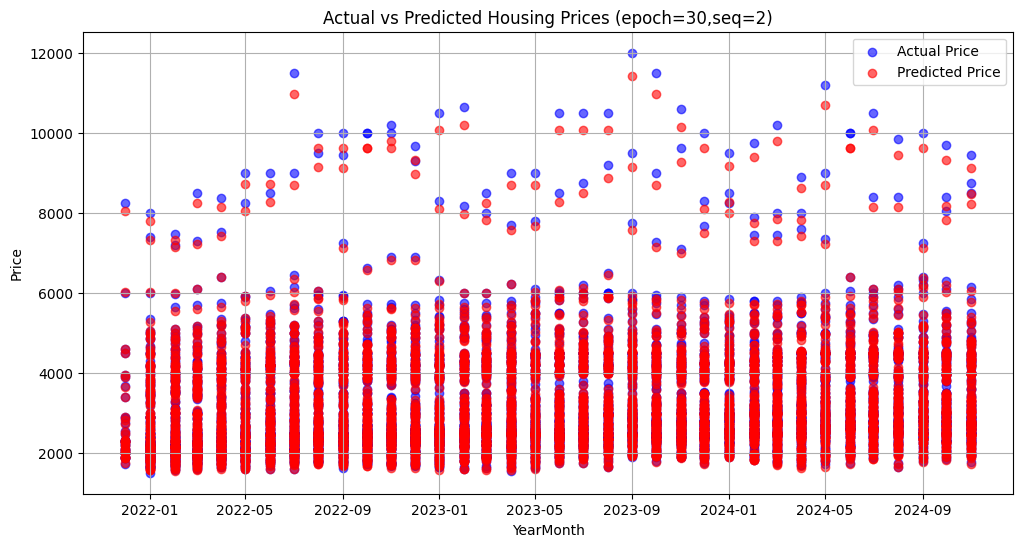

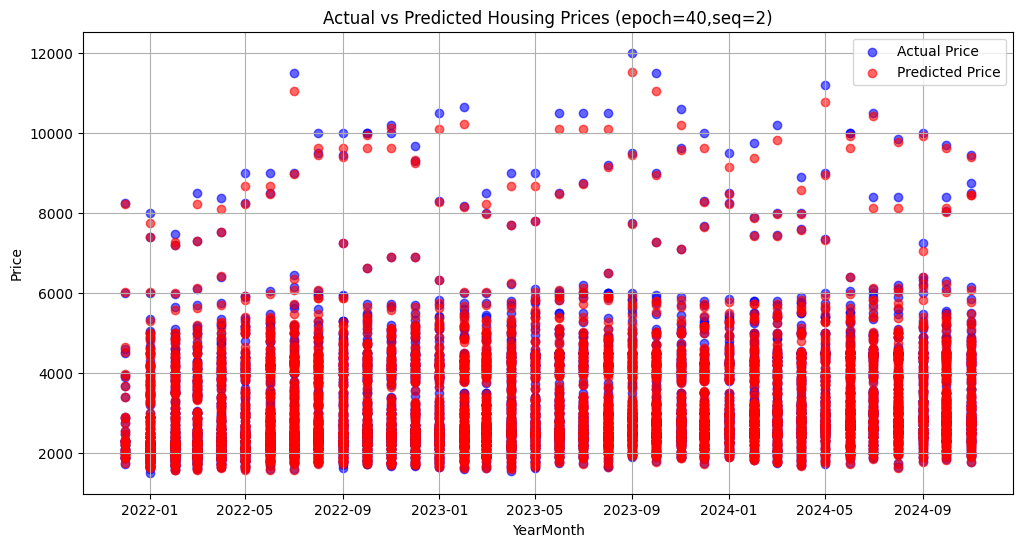

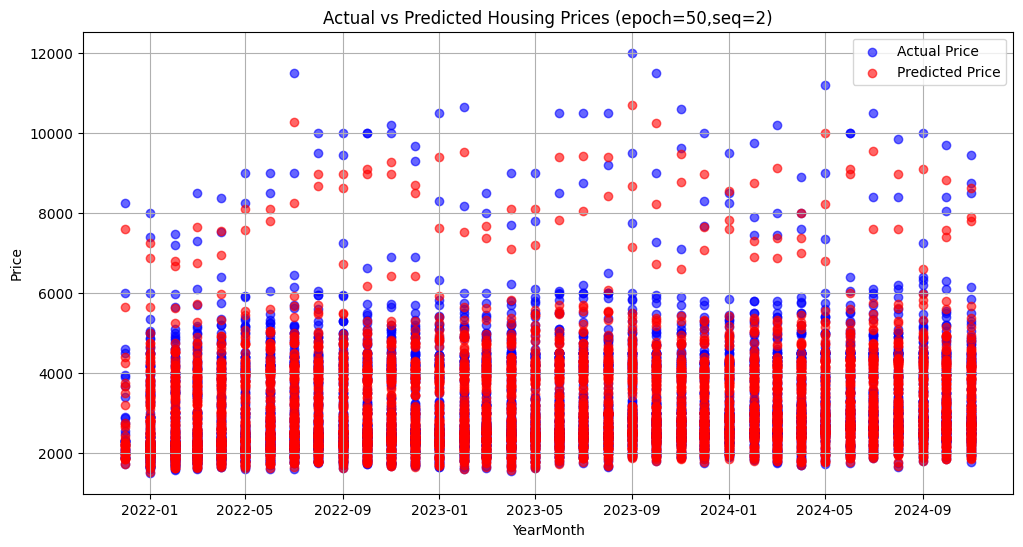

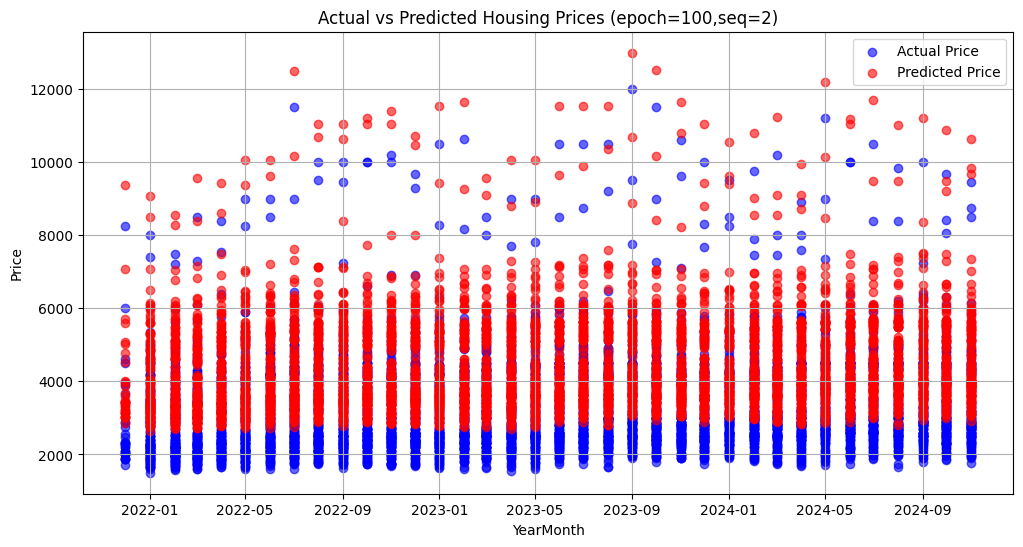

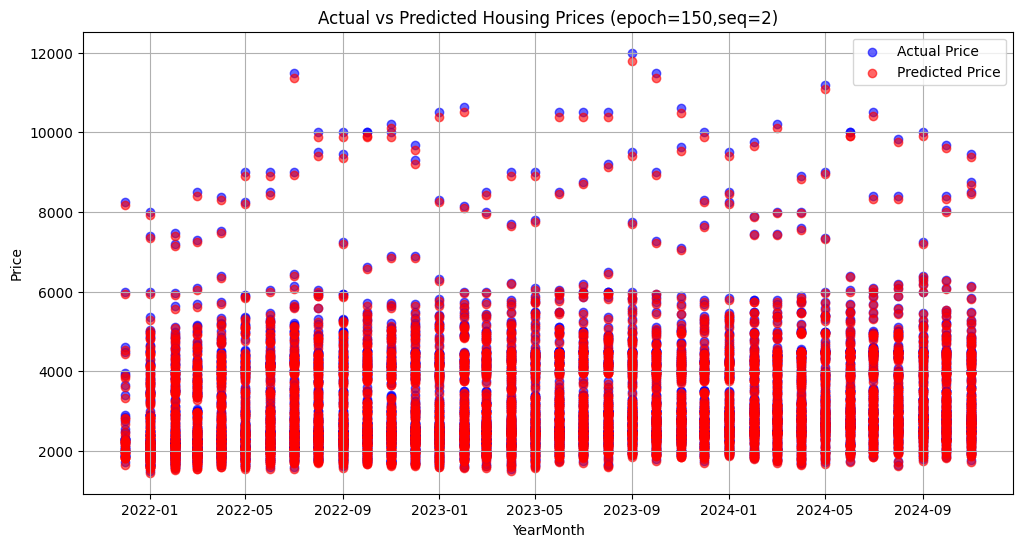

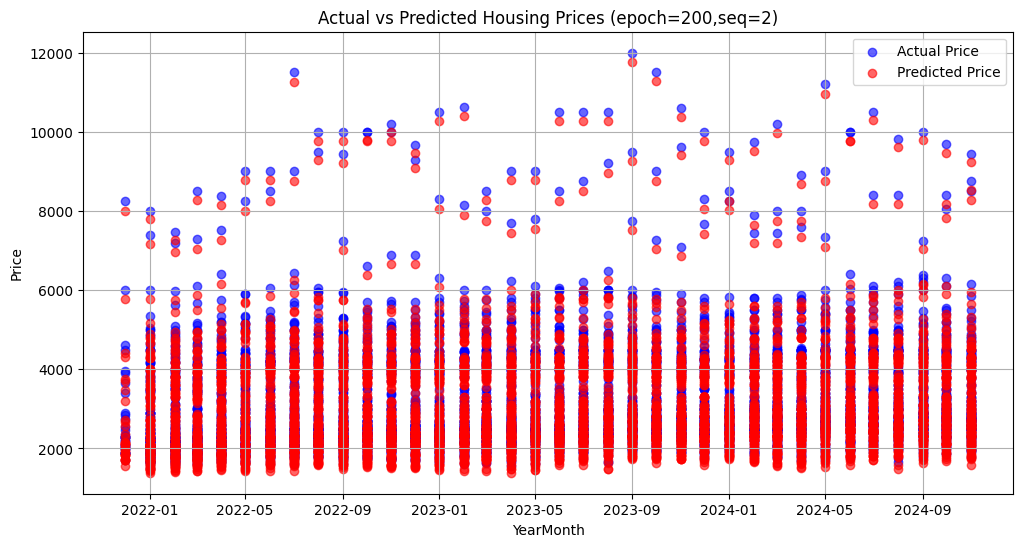

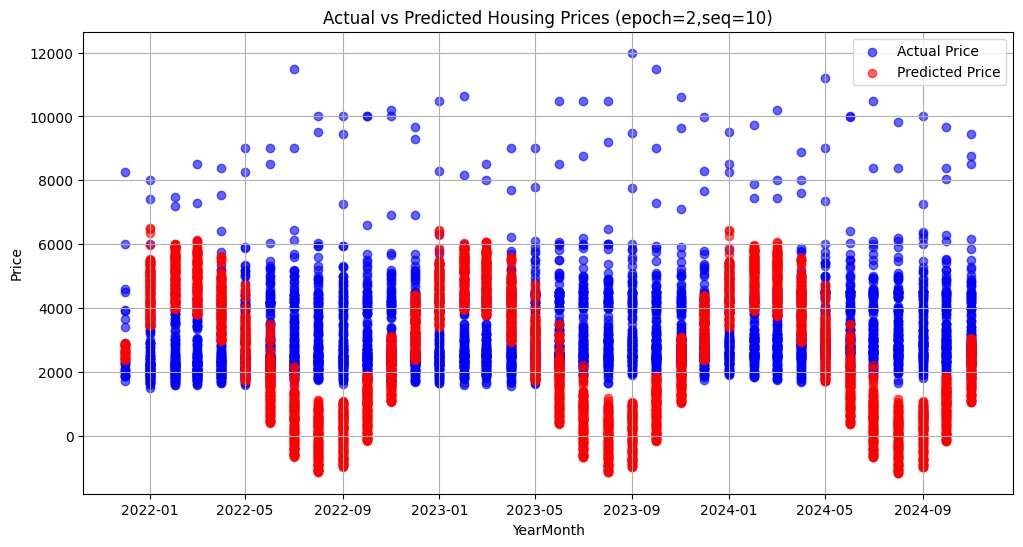

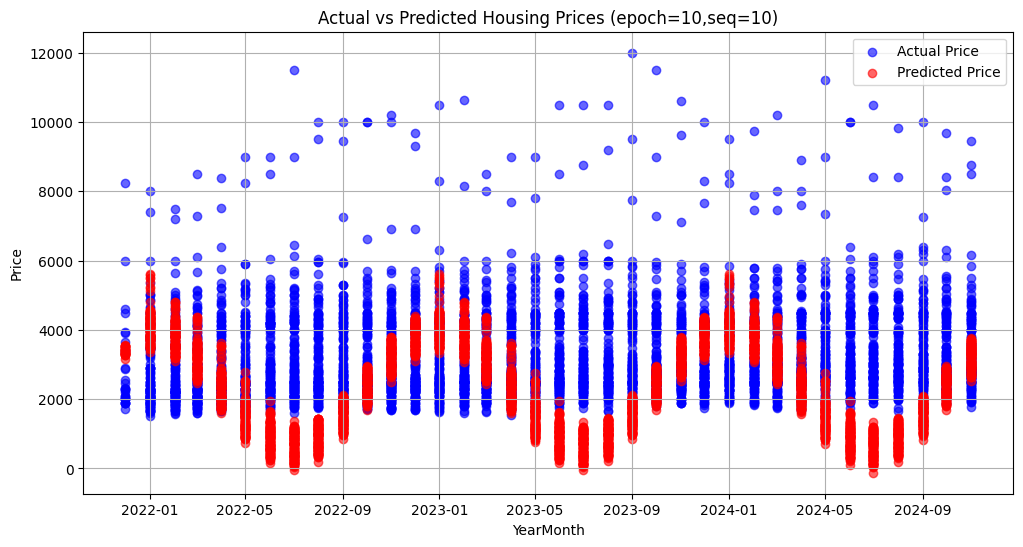

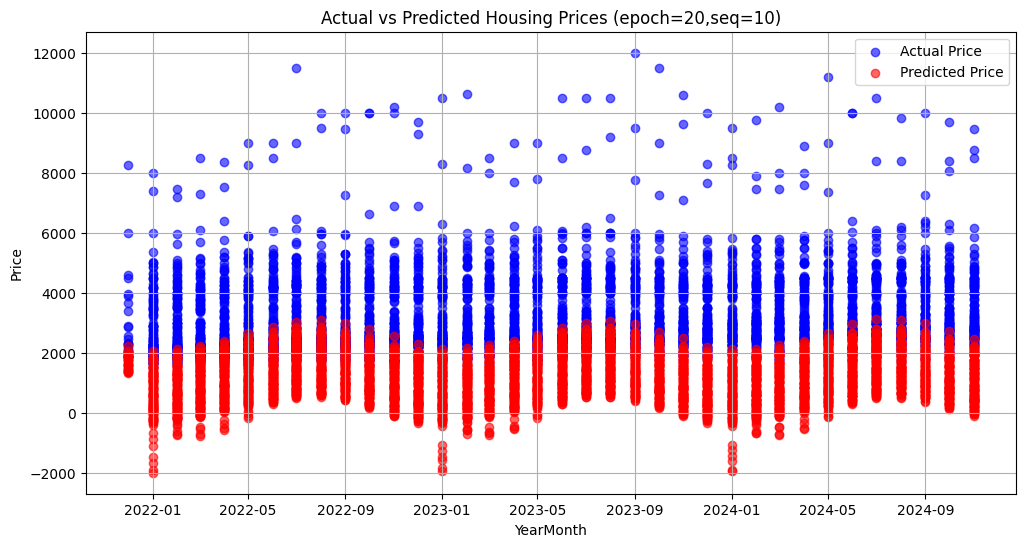

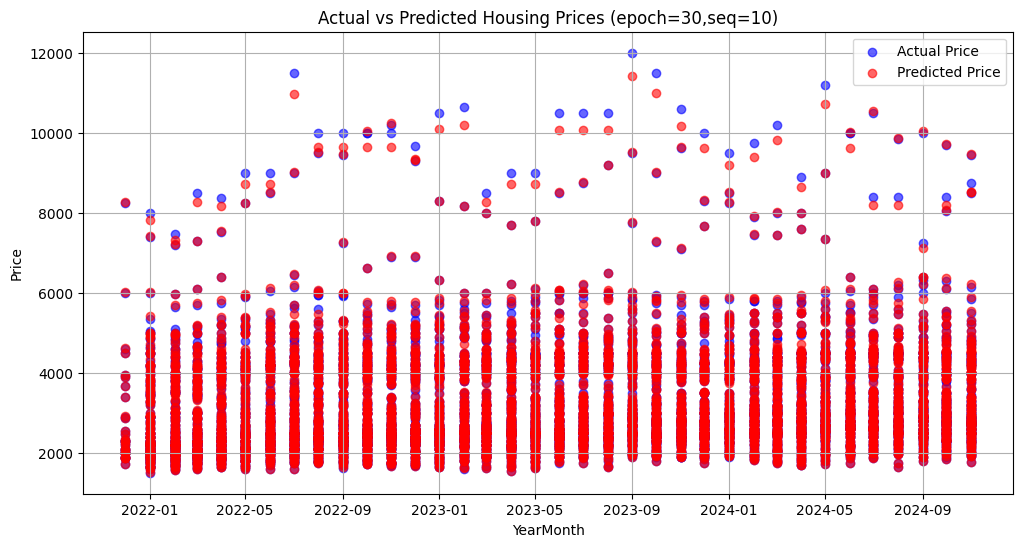

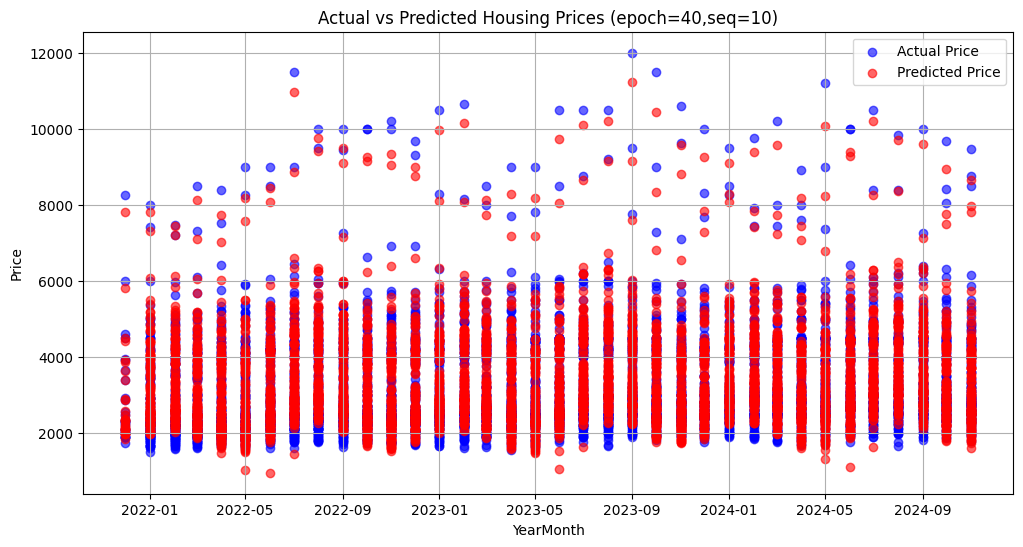

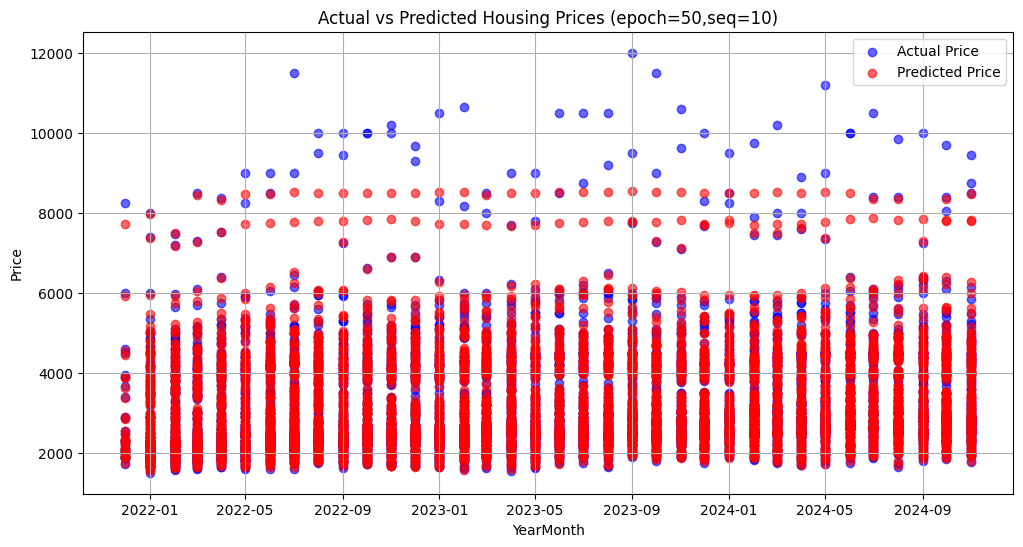

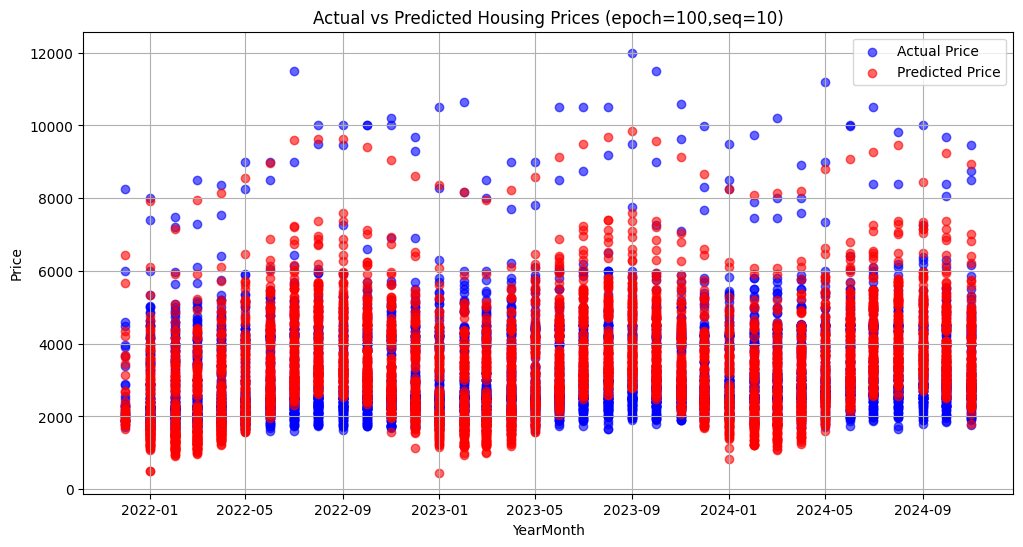

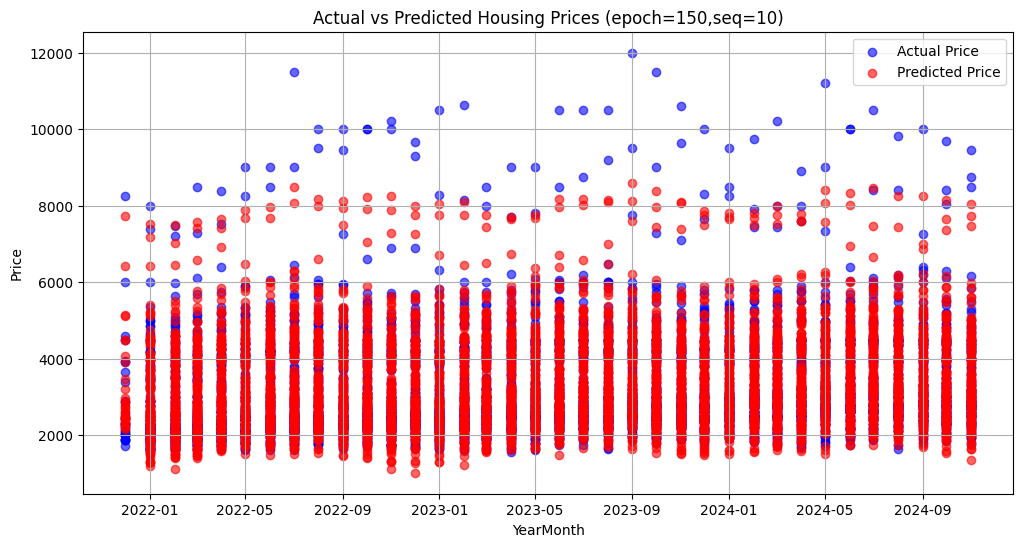

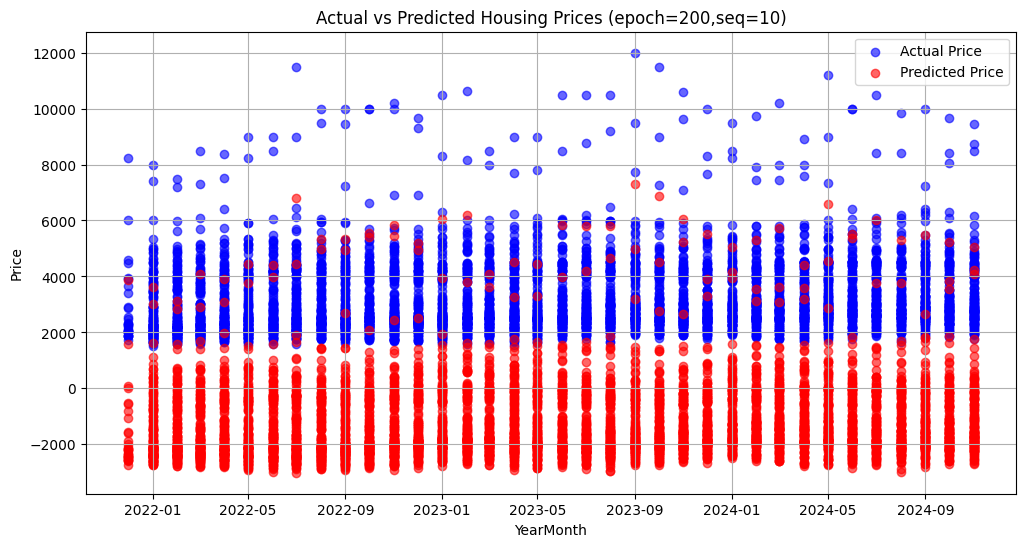

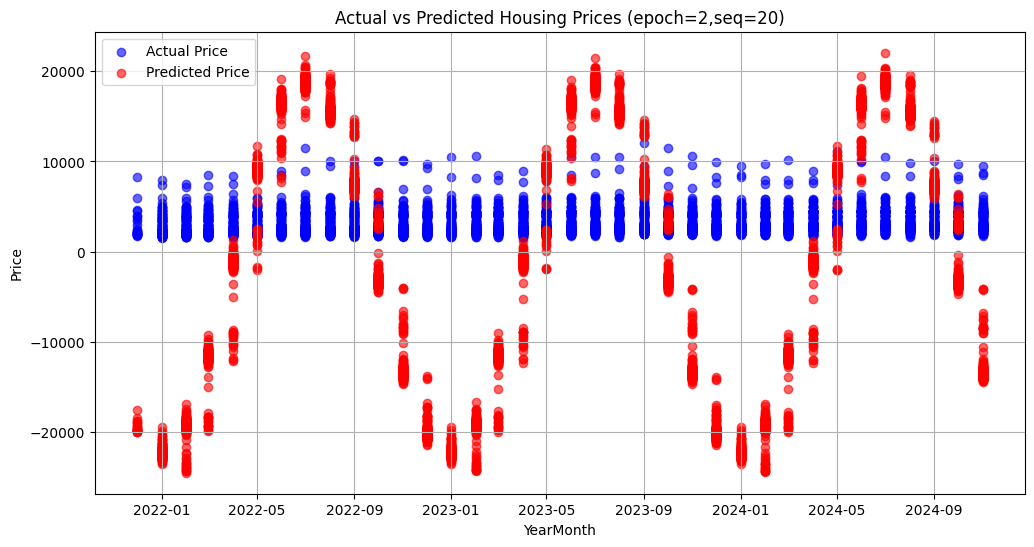

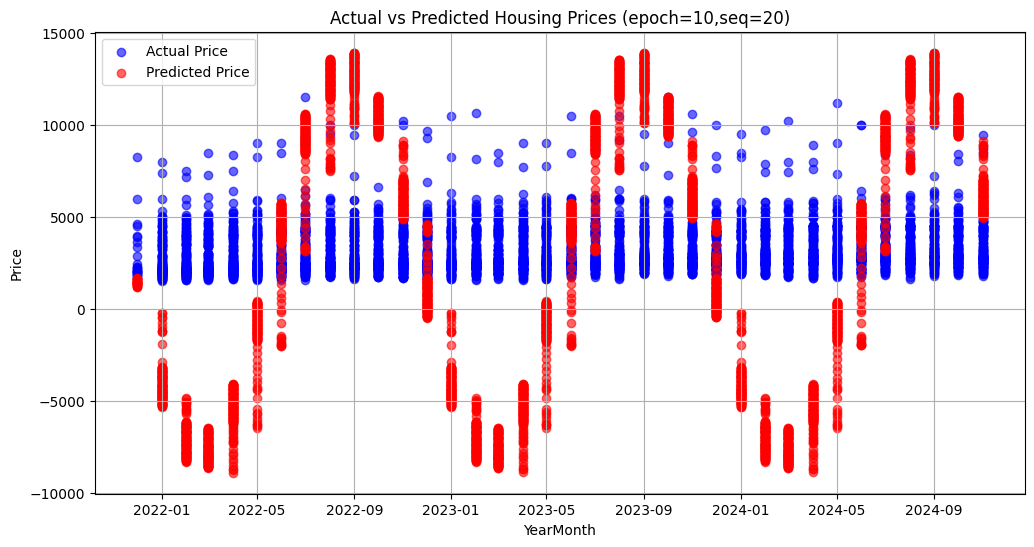

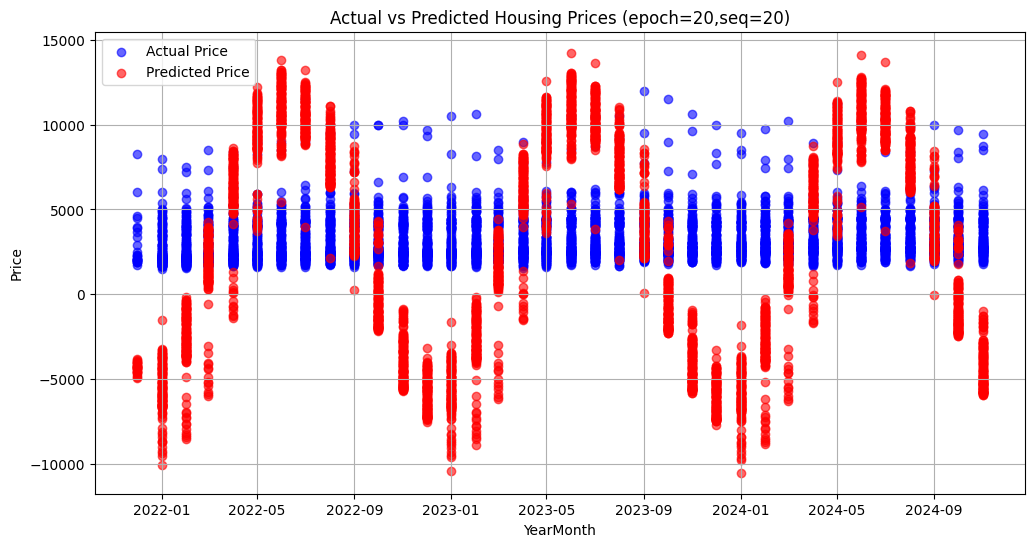

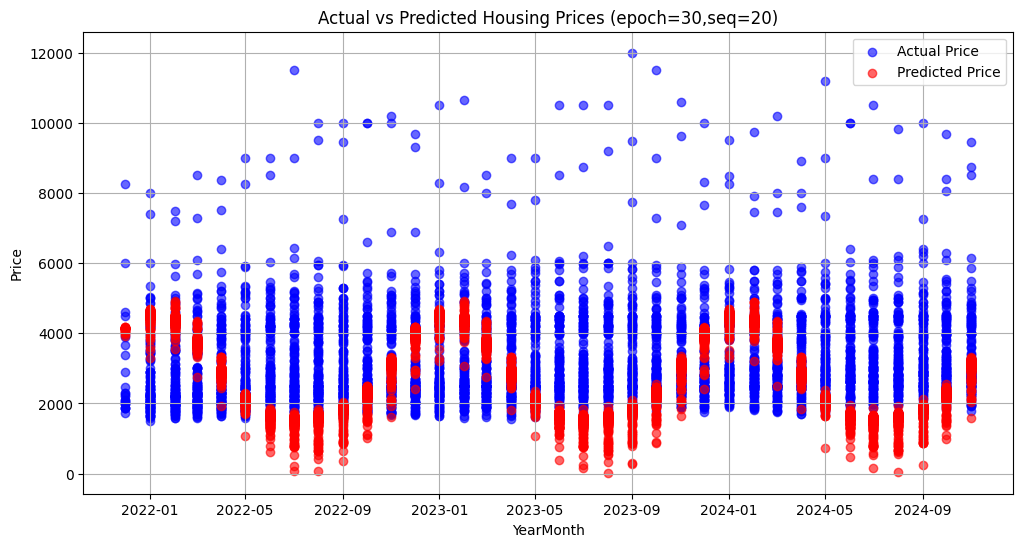

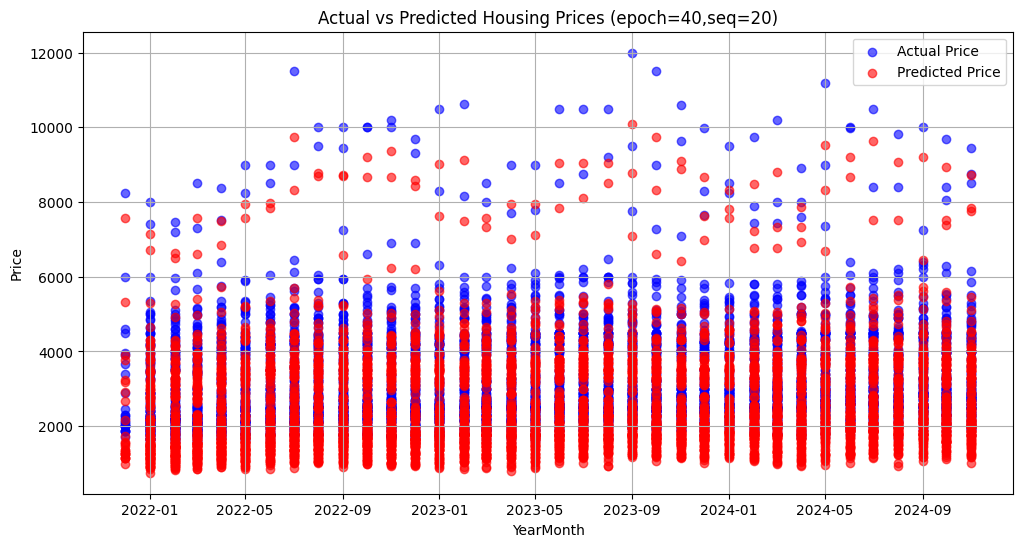

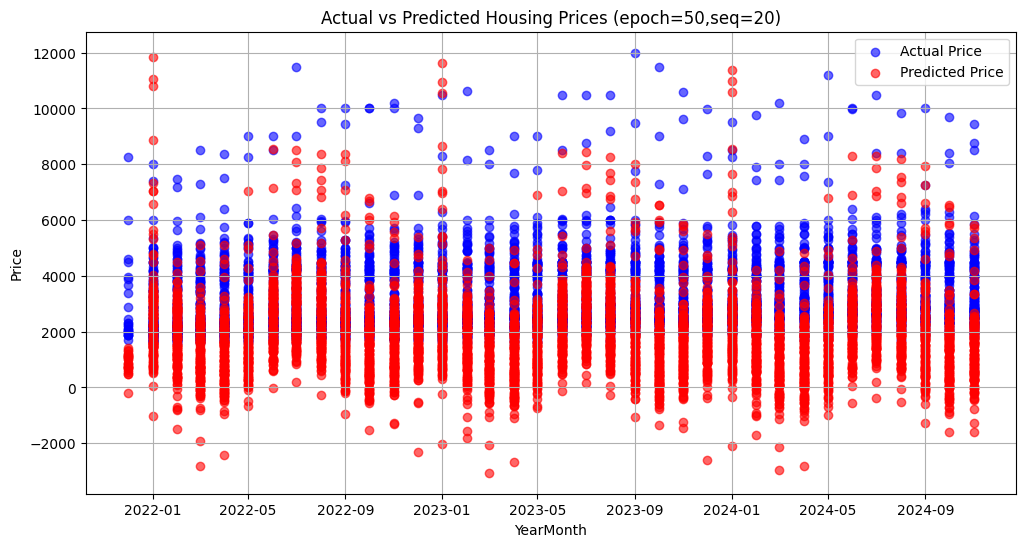

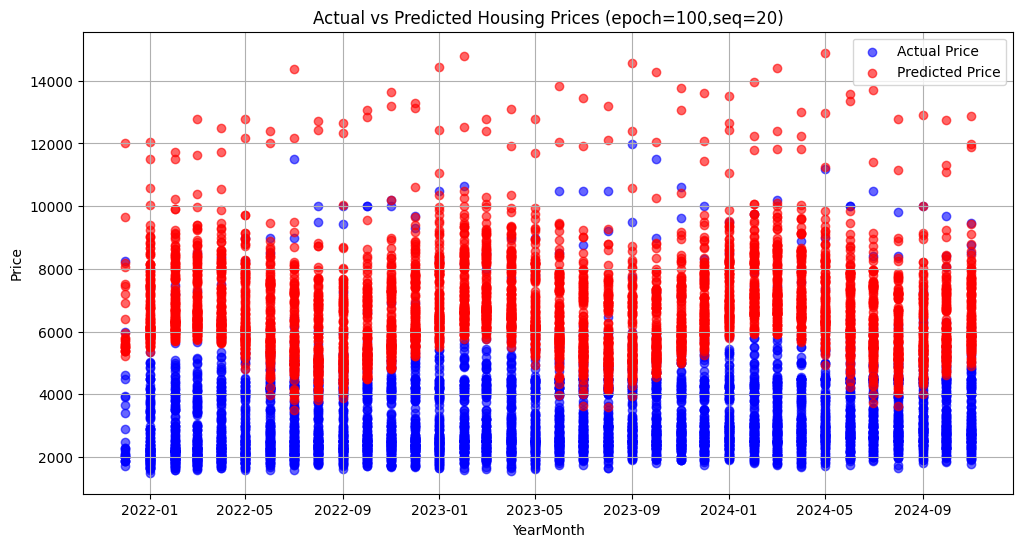

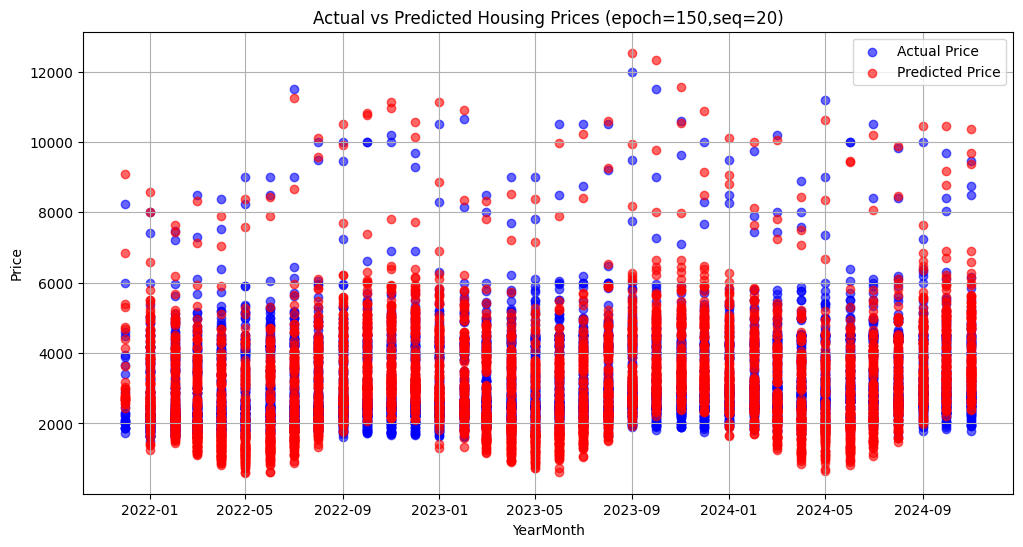

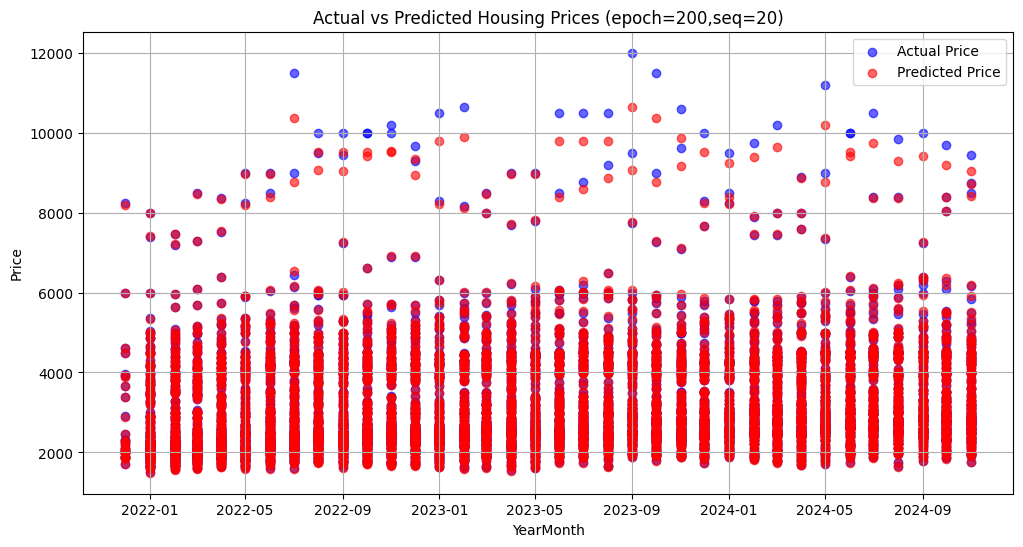

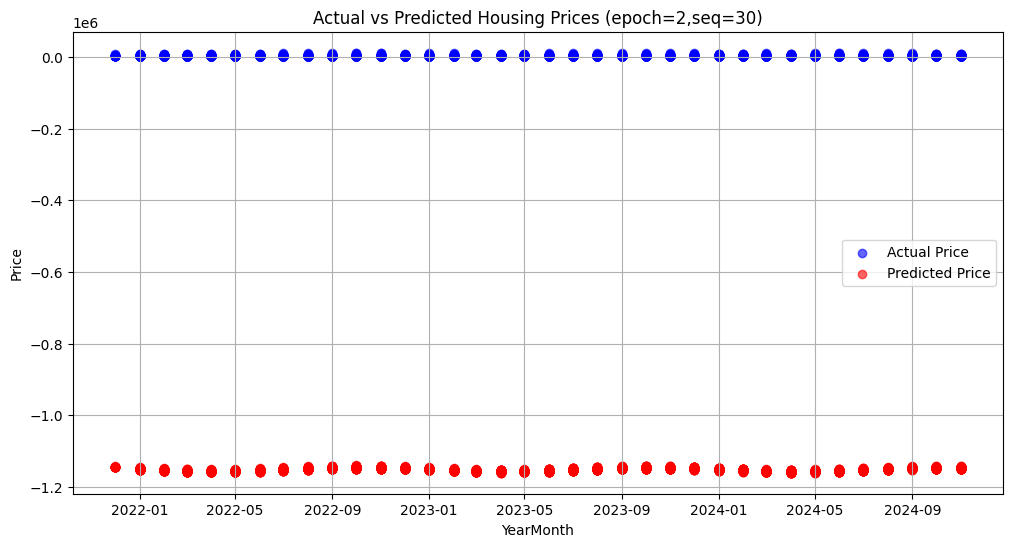

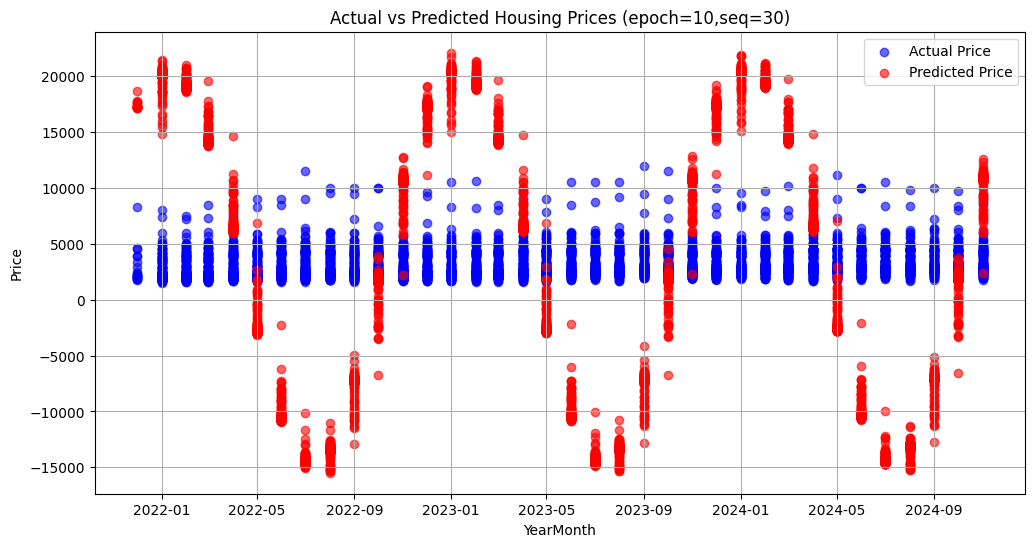

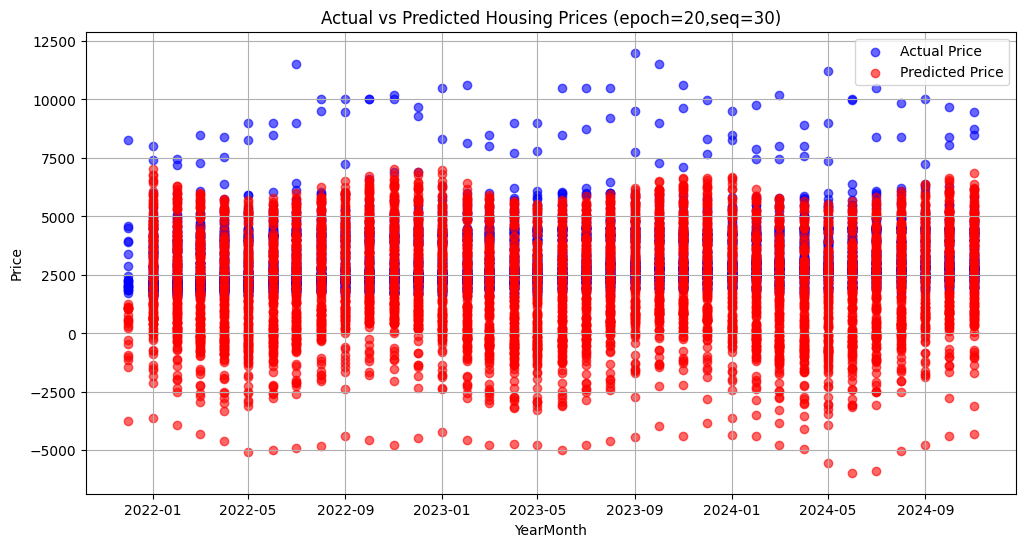

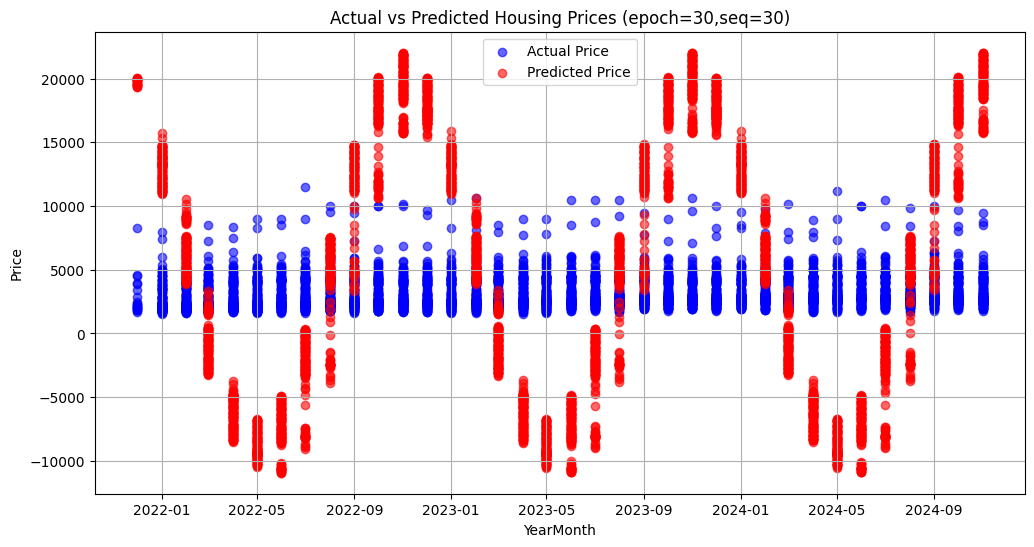

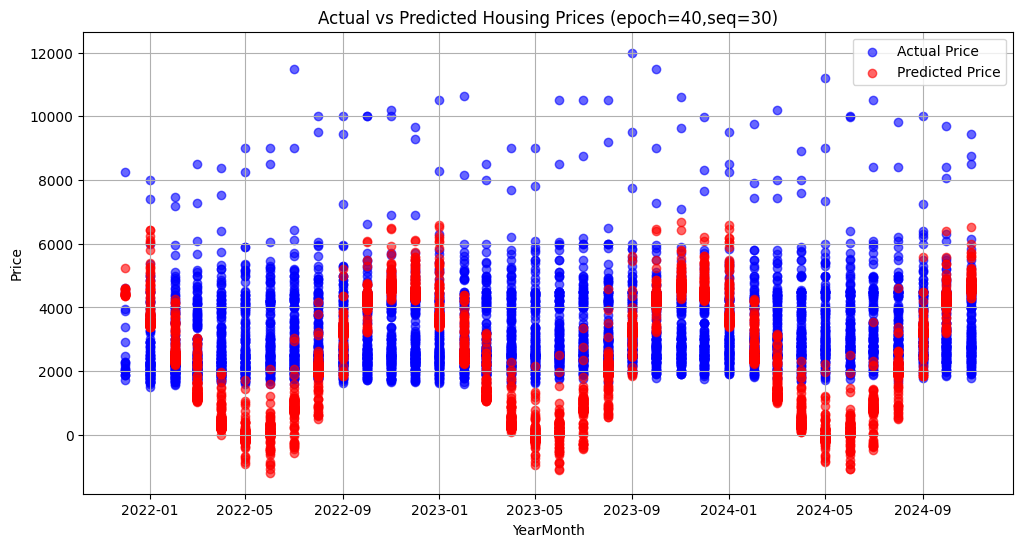

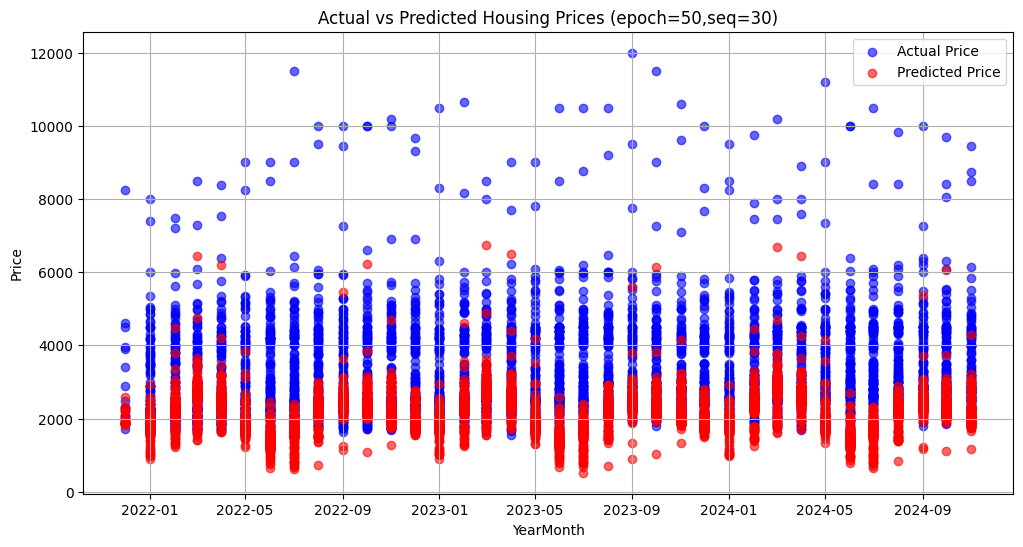

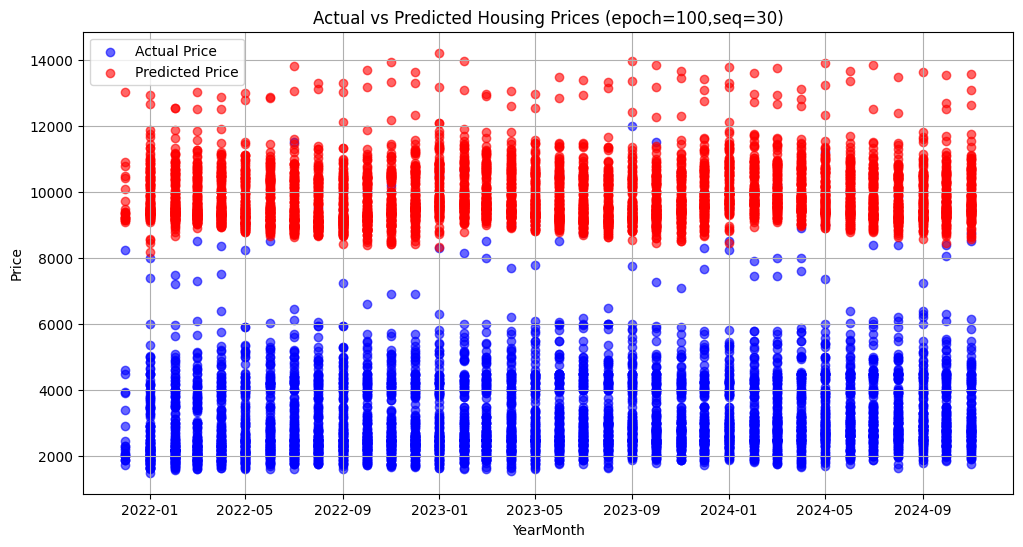

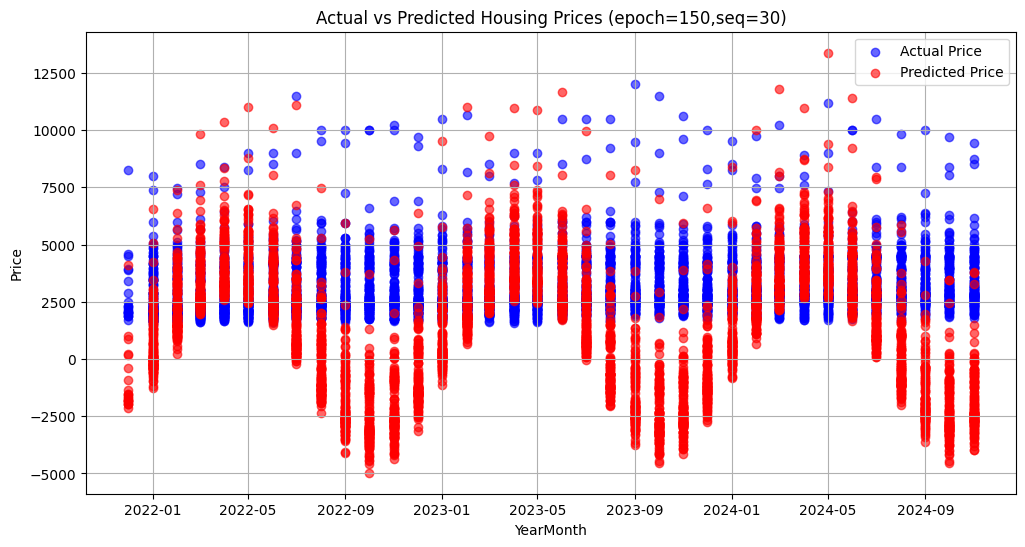

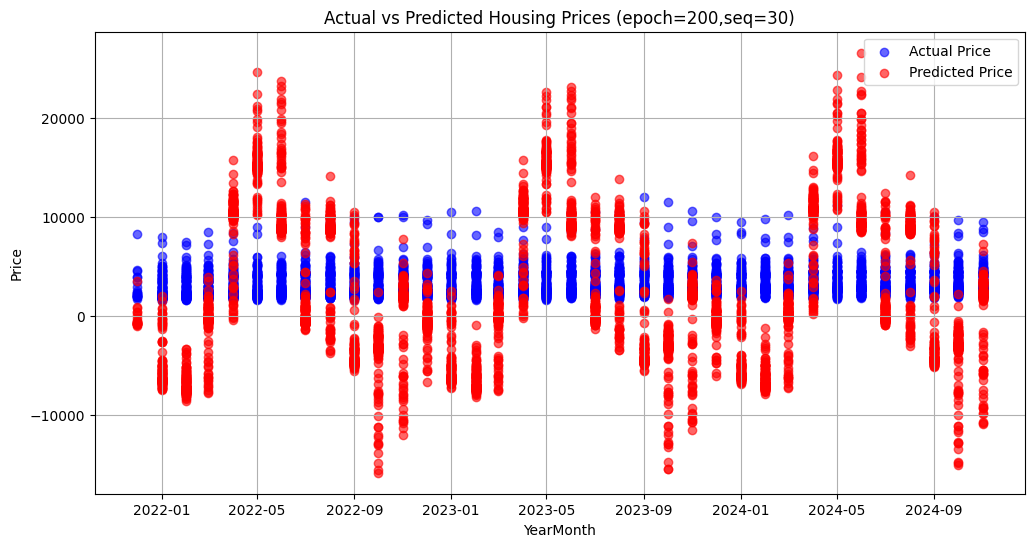

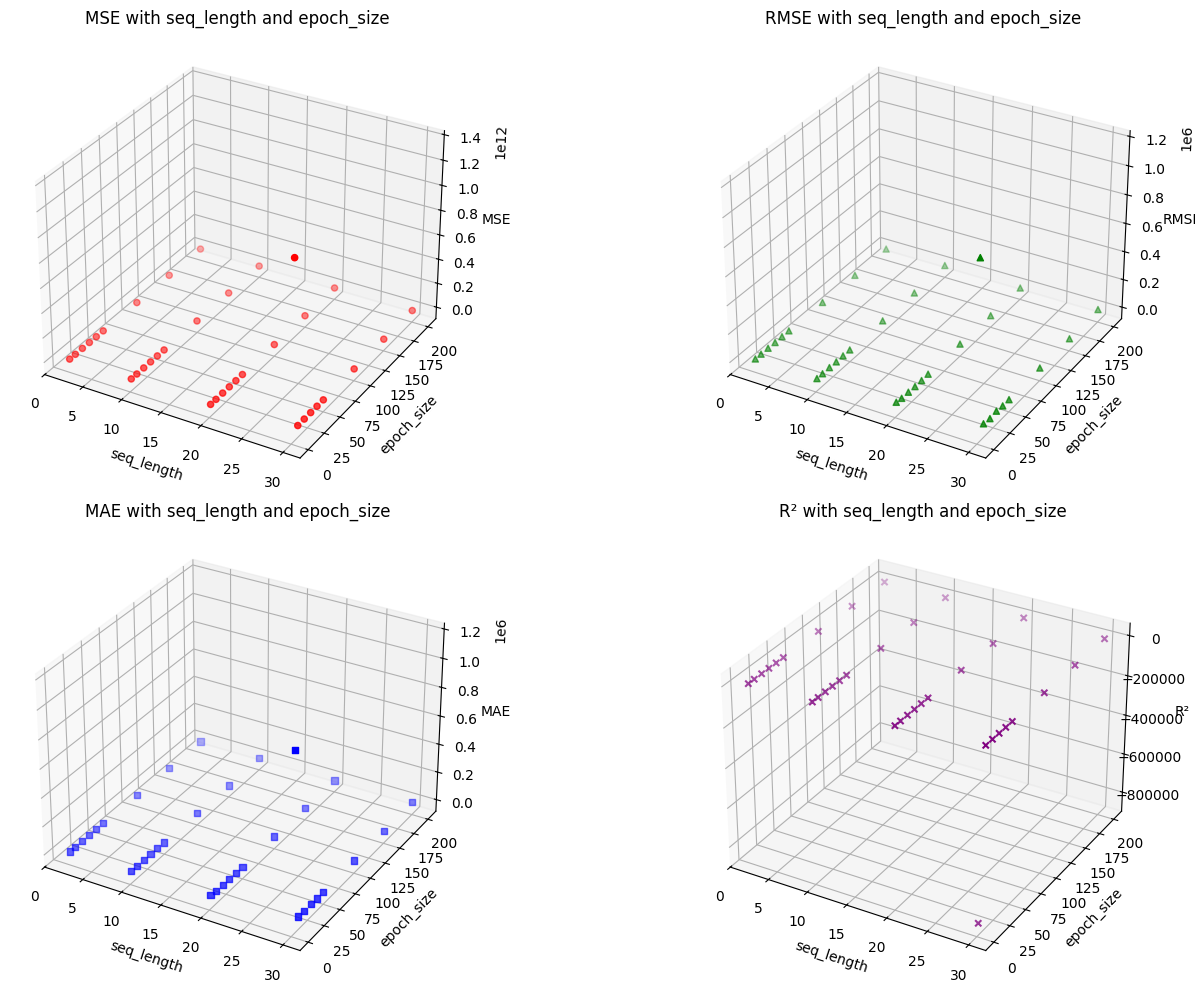

In [ ]:
results = []
# 定义不同的 seq_length 和 epoch
seq_length_list = [2, 10, 20, 30]  # 时间窗口长度
epoch_list = [2, 10, 20, 30, 40, 50, 100, 150, 200]    # 不同的 epoch 数量

for seq_length in seq_length_list:
    for epoch_size in epoch_list:
        mse,rmse,mae,r2 = pre_processing(seq_length,epoch_size)
        results.append({
            'seq_length': seq_length,
            'epoch_size': epoch_size,
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R2': r2
        })

# 转换结果为 DataFrame
results_df = pd.DataFrame(results)  



In [29]:

# 保存图像到本地
file_path = "3d_metrics_plot.png"
plt.savefig(file_path)
plt.close(fig)

print(results_df)  # 查看前几行结果    

    seq_length  epoch_size           MSE          RMSE           MAE  \
0            2           2  1.221790e+06  1.105346e+03  7.662831e+02   
1            2          10  1.824944e+06  1.350905e+03  9.522712e+02   
2            2          20  1.557648e+06  1.248058e+03  8.385945e+02   
3            2          30  4.222400e+03  6.498000e+01  4.317859e+01   
4            2          40  2.219005e+03  4.710632e+01  2.492166e+01   
5            2          50  4.232686e+04  2.057349e+02  1.414356e+02   
6            2         100  1.275877e+06  1.129547e+03  1.129401e+03   
7            2         150  2.332373e+03  4.829465e+01  4.705362e+01   
8            2         200  3.524273e+04  1.877305e+02  1.871372e+02   
9           10           2  6.355313e+06  2.520975e+03  2.046151e+03   
10          10          10  4.192023e+06  2.047443e+03  1.588657e+03   
11          10          20  5.932955e+06  2.435766e+03  2.059253e+03   
12          10          30  1.967305e+03  4.435431e+01  1.699454

<Figure size 640x480 with 0 Axes>